In [13]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re 
import seaborn as sns
from nba_api.stats.endpoints import teamyearbyyearstats
from nba_api.stats.static import teams
%matplotlib inline

In [3]:
#We'll start from 1990/1991 Season to 2016/2017
#Pull all player data and clean
full_player_data = pd.DataFrame()
for i in range(1991,2020):
    url = 'https://www.basketball-reference.com/leagues/NBA_{}_per_game.html'.format(i)
    html = urlopen(url)
    soup = BeautifulSoup(html, 'html.parser')
    column_headers = [th.getText() for th in
                  soup.findAll('tr', limit=1)[0].findAll('th')[1:]]

    data_rows = soup.findAll('tr')[1:]
    player_data = [[td.getText() for td in data_rows[i].findAll('td')]
            for i in range(len(data_rows))]
    player_data_02 = []  # create an empty list to hold all the data

    for j in range(len(data_rows)):  # for each table row
        player_row = []  # create an empty list for each player

        # for each table data element from each table row
        for td in data_rows[j].findAll('td'):
            # get the text content and append to the player_row
            player_row.append(td.getText())

        # then append each pick/player to the player_data matrix
        player_data_02.append(player_row)
    df = pd.DataFrame(player_data, columns=column_headers)
    df.fillna(0, inplace=True)
    df.columns = df.columns.str.replace('%', '_Perc')
    df.rename(columns={'PS/G':'PS_per_game'}, inplace=True)
    df.rename(columns={'MP':'MP_per_game'}, inplace=True)
    cols = df.columns.drop(['Player', 'Pos', 'Tm'])
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df = df[:].fillna(0)
    df.insert(0, 'Season', '{}'.format(str(i-1) + "-" + str(i)[-2:]))
    full_player_data = full_player_data.append(df, ignore_index=True)


In [5]:
full_player_data.head()

Season              Player Pos  Age   Tm   G  GS  MP_per_game   FG   FGA  \
0  1990-91      Alaa Abdelnaby  PF   22  POR  43   0          6.7  1.3   2.7   
1  1990-91  Mahmoud Abdul-Rauf  PG   21  DEN  67  19         22.5  6.2  15.1   
2  1990-91          Mark Acres   C   28  ORL  68   0         19.3  1.6   3.1   
3  1990-91       Michael Adams  PG   28  DEN  66  66         35.5  8.5  21.5   
4  1990-91        Mark Aguirre  SF   31  DET  78  13         25.7  5.4  11.7   

   ...  FT_Perc  ORB  DRB  TRB   AST  STL  BLK  TOV   PF   PTS  
0  ...    0.568  0.6  1.4  2.1   0.3  0.1  0.3  0.5  0.9   3.1  
1  ...    0.857  0.5  1.3  1.8   3.1  0.8  0.1  1.6  2.2  14.1  
2  ...    0.653  2.1  3.2  5.3   0.4  0.4  0.4  0.6  3.2   4.2  
3  ...    0.879  0.9  3.0  3.9  10.5  2.2  0.1  3.6  2.5  26.5  
4  ...    0.757  1.7  3.1  4.8   1.8  0.6  0.3  1.6  2.7  14.2  

[5 rows x 30 columns]

In [4]:
full_player_data.to_csv('full_player_data.csv', index=False)

In [96]:
nba_teams = teams.get_teams()
nba_teams[0]['id']

1610612737

In [98]:
#Grab team standings info
full_team_info = pd.DataFrame()
for i in nba_teams: 
    team_info = teamyearbyyearstats.TeamYearByYearStats(league_id='00',
                                                  per_mode_simple='Totals'
                                                  , season_type_all_star='Regular Season'
                                                             , team_id=i['id']).get_data_frames()[0]
    full_team_info = full_team_info.append(team_info)
    print(i)
    time.sleep(0.5)
full_team_info.head()

ConnectionError: ('Connection aborted.', OSError("(10060, 'WSAETIMEDOUT')"))

In [ ]:
#Merge player stats with team standings

In [7]:
full_player_data.columns

Index(['Season', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP_per_game', 'FG',
       'FGA', 'FG_Perc', '3P', '3PA', '3P_Perc', '2P', '2PA', '2P_Perc',
       'eFG_Perc', 'FT', 'FTA', 'FT_Perc', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

## Prepare Data

In [89]:
full_player_data['Pos'] = full_player_data['Pos'].apply(lambda x : str(x).replace('0', 'NA')[:2].replace('-', ''))

In [31]:
#Classify data as continuous or categorical
cat_vars = ['Season', 'Pos', 'Age', 'Tm']

cont_vars = ['G', 'GS', 'MP_per_game', 'FG',
        'FG_Perc', '3P', '3P_Perc', 
       'eFG_Perc', 'FT', 'FT_Perc', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PTS']

In [48]:
#Perfrom K-means clustering to cluster seasons
from sklearn.ensemble import RandomForestClassifier
#Scale the train features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#Import PCA for dimensionality reduction
from sklearn.decomposition import PCA

In [49]:
#Scale the continous dataset for Kmeans
scaler.fit(full_player_data[cont_vars])
df_scaled = scaler.transform(full_player_data[cont_vars])
df = pd.DataFrame(df_scaled, columns=cont_vars)
df.head(1)

C:\Users\miah.stewart\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\miah.stewart\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


G        GS  MP_per_game        FG   FG_Perc        3P   3P_Perc  \
0 -0.106724 -0.786079    -1.151522 -0.703873  0.449093 -0.754882 -1.172229   

   eFG_Perc        FT   FT_Perc       TRB       AST       STL       BLK  \
0  0.190898 -0.587004 -0.385755 -0.472939 -0.784027 -1.095152 -0.166015   

        TOV       PTS  
0 -0.778661 -0.752811

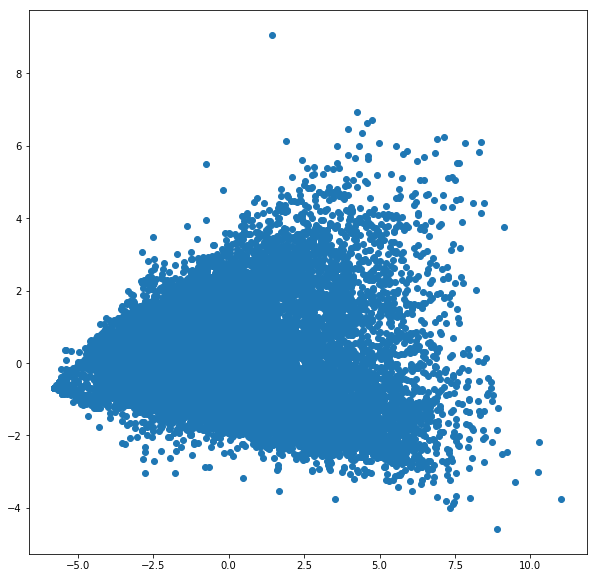

In [51]:
pca = PCA(2)
df_pca = pca.fit_transform(df)
plt.figure(figsize = (10,10))
plt.scatter(x=df_pca[:,0], y=df_pca[:,1])
plt.show()

In [60]:
#scaled with position indicator
df_scaled_w_pos = df.copy()
df_scaled_w_pos.reset_index()
df_scaled_w_pos.head()

G        GS  MP_per_game        FG   FG_Perc        3P   3P_Perc  \
0 -0.106724 -0.786079    -1.151522 -0.703873  0.449093 -0.754882 -1.172229   
1  0.763465 -0.103963     0.326411  1.538691 -0.013991 -0.116343  0.119039   
2  0.799722 -0.786079     0.027083 -0.566573  0.714797 -0.754882  0.619406   
3  0.727207  1.583375     1.542431  2.591323 -0.158230  3.235990  0.420335   
4  1.162301 -0.319368     0.625739  1.172558  0.357995 -0.275978  0.484899   

   eFG_Perc        FT   FT_Perc       TRB       AST       STL       BLK  \
0  0.190898 -0.587004 -0.385755 -0.472939 -0.784027 -1.095152 -0.166015   
1 -0.161162 -0.075168  0.794476 -0.591553  0.776024  0.397073 -0.579831   
2  0.463924 -0.294526 -0.038628  0.792268 -0.728311 -0.455627  0.040892   
3  0.040015  4.092636  0.884320  0.238740  4.899014  3.381522 -0.579831   
4  0.198083  1.240981  0.386092  0.594580  0.051715 -0.029277 -0.166015   

        TOV       PTS  
0 -0.778661 -0.752811  
1  0.578477  1.108456  
2 -0.655285 -0.566685  
3  3.046001  3.206611  
4  0.578477  1.125376

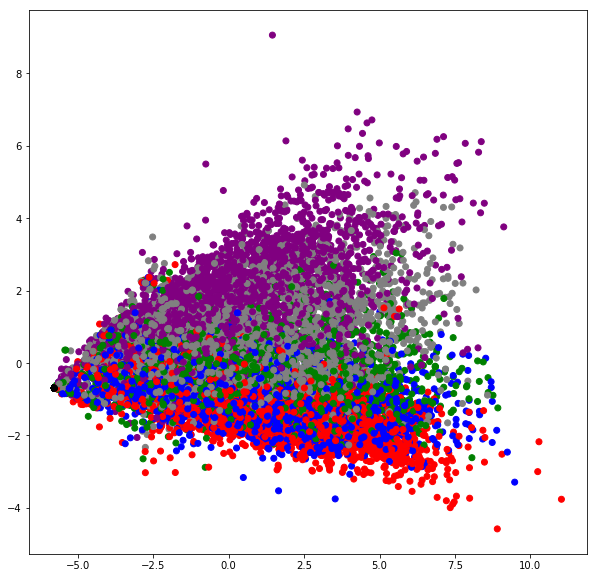

In [94]:
pca = PCA(2)
df_pca = pca.fit_transform(df_scaled_w_pos)
plt.figure(figsize = (10,10))
colors = {'PG':'red', 'SG':'blue', 'SF':'green', 'PF':'grey', 'C':'purple', 'NA':'black'}
plt.scatter(x=df_pca[: ,0], y=df_pca[:,1], c=full_player_data['Pos'].apply(lambda x : colors[x]))
# plt.show()

In [90]:
full_player_data['Pos'].unique()

array(['PF', 'PG', 'C', 'SF', 'SG', 'NA'], dtype=object)

In [139]:
#average of important features on variables to include for further separation
pos_means = full_player_data.groupby('Pos').agg({'TRB': 'mean',
                                     'PTS': 'mean',
                                     'AST': 'mean',
                                     'STL': 'mean'}).\
                                    reset_index(drop=False).rename(lambda c: c + '_avg' if c!='Pos' else c, axis = 1)
pos_means
full_player_data_w_mean = full_player_data.merge(pos_means, on='Pos', how='inner')

In [181]:
#Scale the continous dataset for Kmeans
scaler = StandardScaler()
regex = re.compile(r'.*avg')
avg_cols = list(filter(regex.match, list(full_player_data_w_mean.columns.values)))
scaler.fit(full_player_data_w_mean[cont_vars + avg_cols])
df_scaled = scaler.transform(full_player_data_w_mean[cont_vars + avg_cols])
df = pd.DataFrame(df_scaled, columns=[cont_vars + avg_cols])
df.head(1)

C:\Users\miah.stewart\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\miah.stewart\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


G        GS MP_per_game        FG   FG_Perc        3P   3P_Perc  \
0 -0.106724 -0.786079   -1.151522 -0.703873  0.449093 -0.754882 -1.172229   

   eFG_Perc        FT   FT_Perc       TRB       AST       STL       BLK  \
0  0.190898 -0.587004 -0.385755 -0.472939 -0.784027 -1.095152 -0.166015   

        TOV       PTS   TRB_avg   PTS_avg   AST_avg   STL_avg  
0 -0.778661 -0.752811  1.003521  0.016098 -0.613289 -0.405222

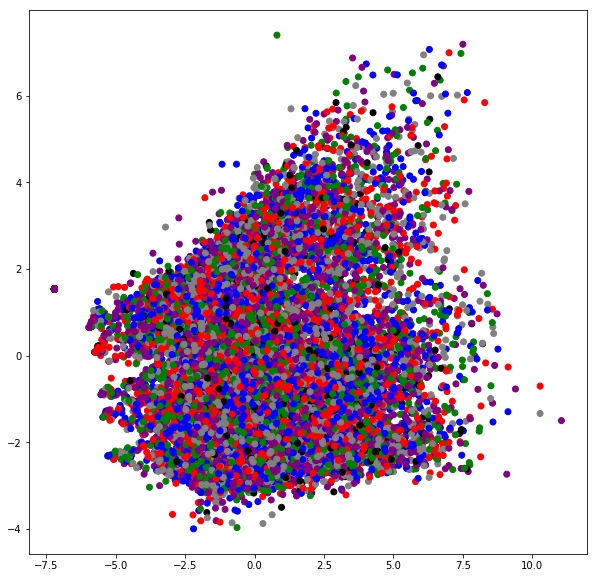

In [180]:
#scaled with position indicator
# df_scaled_w_pos = df.copy()
# df_scaled_w_pos.reset_index()
# df_scaled_w_pos.head()
#Now PCA
pca = PCA(2)
df_pca = pca.fit_transform(df)
plt.figure(figsize = (10,10))
colors = {'PG':'red', 'SG':'blue', 'SF':'green', 'PF':'grey', 'C':'purple', 'NA':'black'}
plt.scatter(x=df_pca[: ,0], y=df_pca[:,1], c=full_player_data['Pos'].apply(lambda x : colors[x]))
# plt.show()

In [177]:
full_player_data_w_mean[cont_vars + avg_cols]

G  GS  MP_per_game   FG  FG_Perc   3P  3P_Perc  eFG_Perc   FT  \
0      43   0          6.7  1.3    0.474  0.0    0.000     0.474  0.6   
1      42   1         14.0  2.4    0.440  0.1    0.238     0.451  1.0   
2      68   2         13.6  1.7    0.430  0.0    0.000     0.430  0.9   
3      26   0          9.5  1.0    0.370  0.0    0.000     0.370  0.6   
4       1   0         18.0  4.0    1.000  0.0    0.000     1.000  0.0   
5      41   2         16.1  2.1    0.440  0.0    0.000     0.440  1.1   
6      12   0          4.3  0.5    0.316  0.0    0.000     0.316  0.6   
7      82  22         30.3  4.9    0.458  0.0    0.000     0.458  2.7   
8       7   0          3.7  0.4    0.375  0.0    0.000     0.375  0.3   
9      47   3          7.2  0.9    0.531  0.0    0.000     0.531  0.5   
10     34   6         22.1  3.0    0.448  0.0    0.000     0.448  1.3   
11     75  73         25.5  5.0    0.527  0.0    0.000     0.527  2.6   
12     53   0         14.7  1.9    0.488  0.0    0.000     0.488  1.4   
13     18   0          3.5  0.8    0.452  0.0    0.000     0.452  0.6   
14     42   0          8.2  0.8    0.422  0.0    0.000     0.422  0.2   
15     52   0          7.3  1.1    0.455  0.0    0.000     0.455  0.6   
16     77  48         32.8  8.2    0.511  0.0    0.000     0.511  3.8   
17     51  38         28.6  5.7    0.462  0.0    0.000     0.462  3.2   
18     76  75         32.6  7.3    0.437  0.3    0.274     0.445  5.0   
19     74  68         35.2  6.9    0.467  0.2    0.342     0.473  4.4   
20     58  25         19.3  2.0    0.417  0.0    0.000     0.417  1.2   
21      4   0          6.5  1.0    0.667  0.0    0.000     0.667  1.8   
22     67  62         32.8  7.5    0.484  0.1    0.212     0.487  2.4   
23      9   1         17.7  0.9    0.333  0.0    0.000     0.333  0.1   
24     55  17         18.1  2.1    0.487  0.0    0.500     0.489  1.3   
25     81   2         20.5  3.4    0.428  0.3    0.299     0.446  1.5   
26     54   3         11.2  1.8    0.460  0.0    0.000     0.460  0.8   
27     72   6         21.6  3.4    0.532  0.0    0.000     0.532  2.3   
28     56   4         13.3  2.9    0.416  0.1    0.250     0.425  1.6   
29     75  75         35.3  6.5    0.487  0.0    0.000     0.487  3.6   
...    ..  ..          ...  ...      ...  ...      ...       ...  ...   
16637   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16638   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16639   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16640   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16641   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16642   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16643   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16644   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16645   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16646   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16647   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16648   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16649   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16650   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16651   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16652   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16653   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16654   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16655   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16656   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16657   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16658   0   0          0.0  0.0    0.000  0.0    0.000     0.000  0.0   
16659   0   0          0.0  0.0    0.000  0.0    0.000     0.000  